Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
#Other imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import category_encoders as ce
import numpy


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [4]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [5]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [6]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [7]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [8]:
# Look at data
df

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Other,8/27/2019,NaN,NaN,NaN,6.00,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
419,Other,8/27/2019,NaN,NaN,NaN,6.00,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
420,California,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
421,Other,8/27/2019,NaN,NaN,NaN,7.90,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


## **Do train/ validation/ test split:**
--------------------
Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'])
df = df.sort_index()

In [10]:
train = df['2011-05-16':'2016-12-15']
val   = df['2017-01-04':'2017-12-29']
test  = df['2018-01-02':]

print(df.shape)
print(train.shape,val.shape,test.shape)
print('Total Observations:', train.shape[0]+val.shape[0]+test.shape[0])

(421, 58)
(298, 58) (85, 58) (38, 58)
Total Observations: 421


In [11]:
#Confirm
train.head(1).append(train.tail(1))

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,Other,NaN,NaN,NaN,8.00,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,3.0,2.0,3.0,2.0,3.0,2.0,x,NaN,x,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-12-15,Other,4.5,4.6,NaN,6.99,3.7,NaN,NaN,24.0,18.5,0.65,3.6,4.0,4.0,3.0,3.8,4.3,NaN,3.8,2.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [12]:
val.head(1).append(val.tail(1))

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,California,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.5,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2017-12-29,California,NaN,NaN,NaN,7.89,5.0,NaN,NaN,20.0,21.5,0.74,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [13]:
test.head(1).append(test.tail(1))

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,California,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2026-04-25,California,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


## **Begin with baselines for classification:**

In [14]:
# Determine majority class
target = 'Great'
ytrain = train[target]
ytrain.value_counts(normalize = True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [15]:
# predictions on majority class
majority = ytrain.mode()[0]
ypred = [majority] * len(ytrain)
print('predictions on majority class predicts', len(ypred), 'burritos that are not "great"')

predictions on majority class predicts 298 burritos that are not "great"


In [16]:
# check accuracy of baseline 
ba = accuracy_score(ytrain,ypred)
print(f'baseline accuracy score is {ba:.2f}')

baseline accuracy score is 0.59


In [17]:
yval = val[target]
y_pred = [majority] * len(yval)
va = accuracy_score(yval, y_pred)
print(f'baseline accuracy for validation data is {va:.2f}')

baseline accuracy for validation data is 0.55


## **Use scikit-learn for logistic regression:**

In [18]:
# instantiate class
model = LogisticRegression()

In [19]:
# find features
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [20]:
train.corr()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso,Great
Yelp,1.000000,0.585133,0.013569,0.109067,NaN,NaN,0.397478,0.065553,0.325606,0.274195,-0.000352,0.078049,0.286679,0.005976,-0.072920,0.189677,0.272944,-0.059679,NaN,0.205121
Google,0.585133,1.000000,-0.001470,0.138669,NaN,NaN,0.160693,0.151752,0.223473,0.326674,-0.094125,0.058849,0.332585,0.154295,-0.054090,0.265229,0.269943,-0.024867,NaN,0.159915
Cost,0.013569,-0.001470,1.000000,0.002414,NaN,NaN,-0.079064,0.403674,0.302008,-0.049891,-0.083887,0.168506,0.185456,-0.076590,-0.106477,0.150133,0.050917,-0.163589,NaN,0.142365
Hunger,0.109067,0.138669,0.002414,1.000000,NaN,NaN,0.118518,-0.158323,-0.073466,0.146126,0.087378,0.081790,0.183629,0.121039,0.094913,0.133990,0.168491,0.012002,NaN,0.158043
Mass (g),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Density (g/mL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,0.397478,0.160693,-0.079064,0.118518,NaN,NaN,1.000000,-0.067762,0.527826,0.165723,-0.067528,-0.054290,0.109499,-0.038337,0.045785,0.041607,0.071656,0.040159,NaN,0.045870
Circum,0.065553,0.151752,0.403674,-0.158323,NaN,NaN,-0.067762,1.000000,0.806687,0.048642,-0.186784,0.158569,0.124948,-0.028323,-0.029974,0.102384,0.068080,-0.175470,NaN,0.067621
Volume,0.325606,0.223473,0.302008,-0.073466,NaN,NaN,0.527826,0.806687,1.000000,0.135366,-0.195904,0.101055,0.167131,-0.053833,-0.002003,0.097130,0.091221,-0.135104,NaN,0.072906
Tortilla,0.274195,0.326674,-0.049891,0.146126,NaN,NaN,0.165723,0.048642,0.135366,1.000000,0.287502,0.282051,0.375572,0.244356,0.245504,0.280748,0.353218,0.164170,NaN,0.377766


In [21]:
# Arrange features for x and y
features = ['Cost','Hunger','Tortilla','Temp','Meat','Fillings',
            'Meat:filling','Uniformity','Salsa','Synergy']

xtrain = train[features]

xval = val[features]
yval = val[target]

xtrain.shape, ytrain.shape, xval.shape, yval.shape

((298, 10), (298,), (85, 10), (85,))

In [22]:
# Impute (fill missing values)
imputer = SimpleImputer()
Xitrain = imputer.fit_transform(xtrain)
Xival = imputer.transform(xval)

In [23]:
# Scaler (standardizing columns to be betwen 1 and 0)
scaler = StandardScaler()
X_trains = scaler.fit_transform(Xitrain)
X_vals = scaler.transform(Xival)

In [24]:
# Fit the model
model.fit(X_trains, ytrain)
Y_pred = model.predict(X_vals)
# check accuracy
accuracy_score(yval, Y_pred)

0.8352941176470589

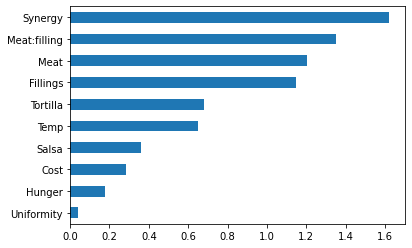

In [25]:
# Find and plot coefficients
coefficients = pd.Series(model.coef_[0], xtrain.columns)
coefficients.sort_values().plot.barh();

## **Get your model's validation accuracy:**
(Multiple times if you try multiple iterations.)

In [26]:
print('Validation Accuracy', f'{model.score(Xival, yval):.2f}')

Validation Accuracy 0.45


## **Get your model's test accuracy:**
(One time, at the end.)

In [27]:
xtest = test[features]
ytest = test[target]
xitest = imputer.transform(xtest)
X_tests = scaler.transform(xitest)
Y_tpred = model.predict(X_tests)
print('Test Accuracy:', f'{model.score(xitest,ytest):.2f}')
print('Test Accuracy Score:',f'{accuracy_score(ytest,Y_tpred):.2f}')

Test Accuracy: 0.58
Test Accuracy Score: 0.79
